In [83]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_img(img, title="Image"):
    plt.figure(figsize=(8, 8))
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap='gray')
    else:  # color
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


# load the unregistered and reference images
unreg = cv2.imread('04292025 AOA5 90kph Run6.mat_WindOn_DF.tif', cv2.IMREAD_UNCHANGED)              # wind on
reference = cv2.imread('04292025 AOA5 90kph Run6.mat_WindOff_DF.tif', cv2.IMREAD_UNCHANGED)         # wind off
print(f"Unregistered image dtype: {unreg.dtype}, shape: {unreg.shape}")
print(f"Reference image dtype: {reference.dtype}, shape: {reference.shape}")

Unregistered image dtype: uint16, shape: (2160, 2560)
Reference image dtype: uint16, shape: (2160, 2560)


In [84]:
print(f"Unregistered image dtype: {unreg.dtype}, shape: {unreg.shape}")
print(f"Reference image dtype: {reference.dtype}, shape: {reference.shape}")
print(unreg.max(), unreg.min())

# convert images to float32 for processing
unreg = unreg.astype(np.float32)
reference = reference.astype(np.float32)

# normalize the values to the range [0, 1]
unreg_norm = cv2.normalize(unreg, None, 0, 1, cv2.NORM_MINMAX)
reference_norm = cv2.normalize(reference, None, 0, 1, cv2.NORM_MINMAX)

print(f"Unregistered image dtype: {unreg_norm.dtype}, shape: {unreg_norm.shape}")
print(f"Reference image dtype: {reference_norm.dtype}, shape: {reference_norm.shape}")
print(unreg.max(), unreg.min())

# Harris corner detection parameters
block_size = 5
aperture_size = 3
k = 0.04
threshold = 0.7

# Run Harris corner detection
dst_unreg = cv2.cornerHarris(unreg_norm, block_size, aperture_size, k)
dst_reference = cv2.cornerHarris(reference_norm, block_size, aperture_size, k)

print(f"Unregistered corner response dtype: {dst_unreg.dtype}, shape: {dst_unreg.shape}")
print(f"Reference corner response dtype: {dst_reference.dtype}, shape: {dst_reference.shape}")
print(dst_unreg.max(), dst_unreg.min())

# Normalize the corner response maps
dst_unreg = cv2.normalize(dst_unreg, None, 0, 1, cv2.NORM_MINMAX)
dst_reference = cv2.normalize(dst_reference, None, 0, 1, cv2.NORM_MINMAX)

print(f"Normalized unregistered corner response dtype: {dst_unreg.dtype}, shape: {dst_unreg.shape}")
print(f"Normalized reference corner response dtype: {dst_reference.dtype}, shape: {dst_reference.shape}")
print(dst_unreg.max(), dst_unreg.min())

# threshold the corner response maps to find strong corners
unreg_strong_corners = dst_unreg > threshold
ref_strong_corners = dst_reference > threshold
print(ref_strong_corners.shape)

unreg_strong_coords = np.argwhere(unreg_strong_corners)
ref_strong_coords = np.argwhere(ref_strong_corners)
print(f"Number of strong corners in unregistered image: {len(unreg_strong_coords)}")
print(f"Number of strong corners in reference image: {len(ref_strong_coords)}")


Unregistered image dtype: uint16, shape: (2160, 2560)
Reference image dtype: uint16, shape: (2160, 2560)
65535 0
Unregistered image dtype: float32, shape: (2160, 2560)
Reference image dtype: float32, shape: (2160, 2560)
65535.0 0.0
Unregistered corner response dtype: float32, shape: (2160, 2560)
Reference corner response dtype: float32, shape: (2160, 2560)
0.0006974193 -0.00036214714
Normalized unregistered corner response dtype: float32, shape: (2160, 2560)
Normalized reference corner response dtype: float32, shape: (2160, 2560)
1.0 -3.2421799e-09
(2160, 2560)
Number of strong corners in unregistered image: 18
Number of strong corners in reference image: 20


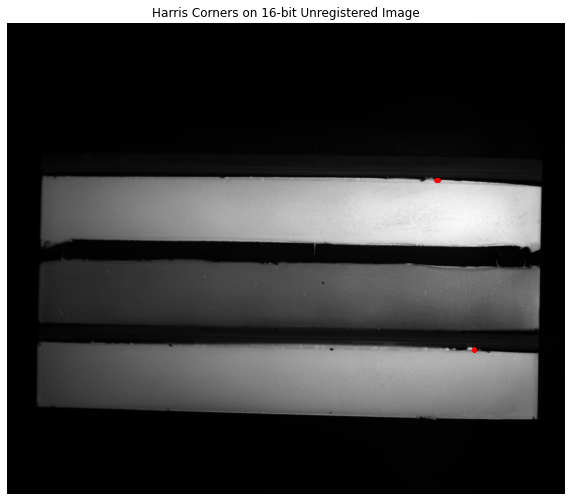

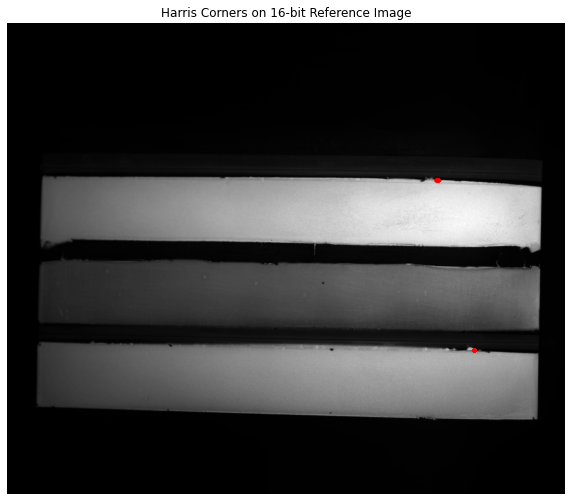

In [85]:
# Plot the original 16-bit reference image
plt.figure(figsize=(10, 10))
plt.imshow(unreg, cmap='gray', vmin=reference.min(), vmax=reference.max())

# Get the coordinates of strong corners
corner_y, corner_x = np.where(unreg_strong_corners)

# Overlay red dots
plt.scatter(corner_x, corner_y, s=10, c='red', marker='o')

plt.title('Harris Corners on 16-bit Unregistered Image')
plt.axis('off')
plt.show()

# Plot the original 16-bit reference image
plt.figure(figsize=(10, 10))
plt.imshow(reference, cmap='gray', vmin=reference.min(), vmax=reference.max())

# Get the coordinates of strong corners
corner_y, corner_x = np.where(ref_strong_corners)

# Overlay red dots
plt.scatter(corner_x, corner_y, s=10, c='red', marker='o')

plt.title('Harris Corners on 16-bit Reference Image')
plt.axis('off')
plt.show()

In [86]:
# extract small areas around corners
def extract_patch(img, center, size=11):
    half = size //2
    x, y = center
    if x - half < 0 or y - half < 0 or x + half >= img.shape[1] or y + half >= img.shape[0]:
        return None # skip edge
    return img[y - half:y + half + 1, x - half:x + half + 1]

# extract patches around strong corners with NCC
def NCC(patch1, patch2):
    if patch1 is None or patch2 is None:
        return 0
    patch1 = patch1 - np.mean(patch1)
    patch2 = patch2 - np.mean(patch2)
    denom = np.std(patch1) * np.std(patch2)
    if denom == 0 :
        return -1
    return np.mean(patch1 * patch2) / denom

matches = []
print(f"Number of strong corners in unregistered image: {len(unreg_strong_coords)}")
print(f"Number of strong corners in reference image: {len(ref_strong_coords)}")

for pt1 in ref_strong_coords:
    #print(f"Processing point {pt1}")
    best_score = -1
    best_match = None
    patch = extract_patch(reference_norm, pt1[::-1])
    #print(patch)
    for pt2 in unreg_strong_coords:
        #print(f"Comparing with point {pt2}")
        patch2 = extract_patch(unreg_norm, pt2[::-1])
        #print(patch2)
        score = NCC(patch, patch2)
        if score > best_score:
            best_score = score 
            best_match = pt2
    if best_score > .99:  # threshold for a good match
        matches.append((tuple(pt1), tuple(best_match)))

print(f"Number of matches found: {len(matches)}")
print(matches[0]) # first match RefX, RefY -> UnregX, UnregY

# plot matches on both images


Number of strong corners in unregistered image: 18
Number of strong corners in reference image: 20
Number of matches found: 20
((719, 1970), (718, 1969))


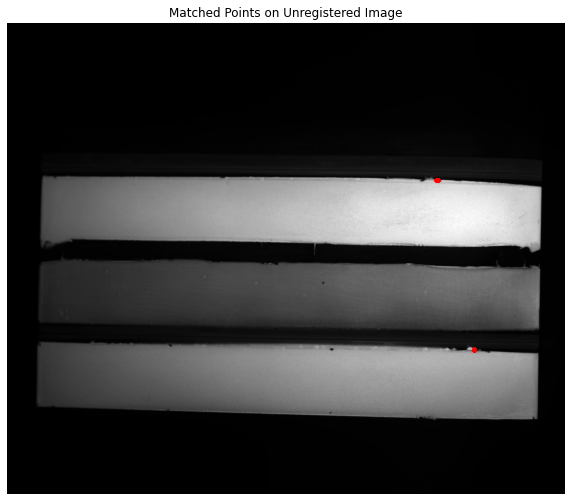

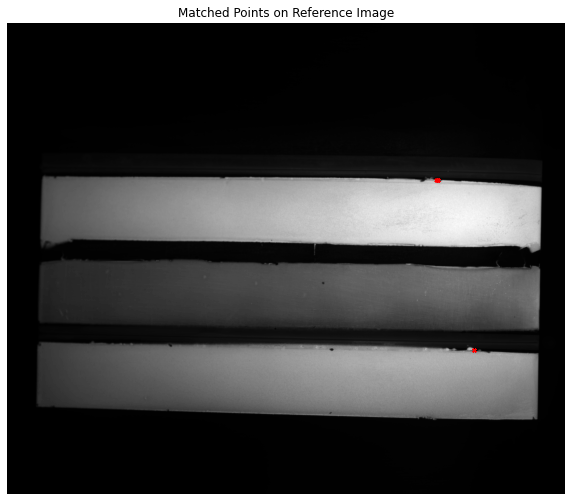

In [87]:
# Extract matched points in unregistered image
unreg_pts = [pt[1] for pt in matches]
x_unreg = [p[1] for p in unreg_pts]
y_unreg = [p[0] for p in unreg_pts]

plt.figure(figsize=(10, 10))
plt.imshow(unreg, cmap='gray', vmin=reference.min(), vmax=reference.max())
plt.scatter(x_unreg, y_unreg, s=10, c='red', marker='o')
plt.title('Matched Points on Unregistered Image')
plt.axis('off')
plt.show()

# Extract matched points in reference image
ref_pts = [pt[0] for pt in matches]
x_ref = [p[1] for p in ref_pts]
y_ref = [p[0] for p in ref_pts]

plt.figure(figsize=(10, 10))
plt.imshow(reference, cmap='gray', vmin=reference.min(), vmax=reference.max())
plt.scatter(x_ref, y_ref, s=10, c='red', marker='x')
plt.title('Matched Points on Reference Image')
plt.axis('off')
plt.show()


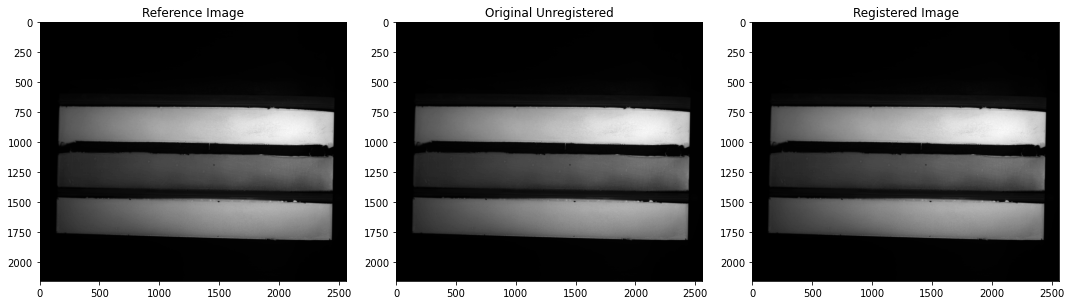

In [88]:
# apply affine transformation to each image
pts_ref = np.float32([pt[0] for pt in matches])
pts_unreg = np.float32([pt[1] for pt in matches])
M, inliers = cv2.estimateAffinePartial2D(pts_ref, pts_unreg, method=cv2.RANSAC)

h, w = reference.shape[:2]
registered = cv2.warpAffine(unreg, M, (w, h))

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(reference, cmap='gray')
plt.title("Reference Image")

plt.subplot(1, 3, 2)
plt.imshow(unreg, cmap='gray')
plt.title("Original Unregistered")

plt.subplot(1, 3, 3)
plt.imshow(registered, cmap='gray')
plt.title("Registered Image")
plt.tight_layout()
plt.show()


In [89]:
# confirm its the right shape and type
print(registered.shape, registered.dtype)
registered_norm = (registered - registered.min()) / (registered.max() - registered.min())
registered_uint16 = (registered_norm * 65535).astype(np.uint16)
print(registered_uint16.shape, registered_uint16.dtype)

# save the registered image
cv2.imwrite('registered_image_test.tif', registered_uint16)

(2160, 2560) float32
(2160, 2560) uint16


True

In [90]:
# Make sure both are float32 and same shape
abs_diff = np.abs(reference.astype(np.float32) - registered.astype(np.float32))
print(f"Mean Absolute Error: {np.mean(abs_diff):.4f}")
print(f"Reference image range: {reference.min()} - {reference.max()}")
print(f"Percentage calculation: {np.mean(abs_diff) / (reference.max() - reference.min()) * 100:.2f}%")

Mean Absolute Error: 223.2984
Reference image range: 0.0 - 64838.0
Percentage calculation: 0.34%
